<a href="https://colab.research.google.com/github/Cospero/Kursovaya-/blob/main/Enassamble_Kursach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def Datapreperation():
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/crypto-markets.csv')
    bitcoin_df = pd.DataFrame(df.loc[df.name =="Bitcoin", ["date", "open", "close", "high", "low"]]).set_index("date")
    bitcoin_df["close_nextday"] = bitcoin_df["close"].shift(periods = -1, fill_value = 0)
    temp = bitcoin_df[["open", "close", "high", "low"]]
    temp = temp[1800:]
    return bitcoin_df, temp

In [ ]:
bitcoin_df, temp = Datapreperation()

In [ ]:
display(bitcoin_df)

,open,close,high,low,close_nextday
date,,,,,
2013-04-28,135.30,134.21,135.98,132.10,144.54
2013-04-29,134.44,144.54,147.49,134.00,139.00
2013-04-30,144.00,139.00,146.93,134.05,116.99
2013-05-01,139.00,116.99,139.89,107.72,105.21
2013-05-02,116.38,105.21,125.60,92.28,97.75
...,...,...,...,...,...
2018-11-25,3880.78,4009.97,4120.87,3585.06,3779.13
2018-11-26,4015.07,3779.13,4107.14,3643.92,3820.72
2018-11-27,3765.95,3820.72,3862.96,3661.01,4257.42


In [ ]:
def TestTrainpreperation(bitcoin_df):
    X = bitcoin_df[["open", "close", "high", "low"]]
    y = bitcoin_df[["close_nextday"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
def LinearRegressionModel(bitcoin_df, X_train, X_test, y_train, y_test, temp, acc):
    regressModel = LinearRegression()
    regressModel.fit(X_train, y_train)

    acc.at["r2_score", "LinearRegression"] = metrics.r2_score(y_test, regressModel.predict(X_test))
    acc.at["mean_squared_error", "LinearRegression"] = metrics.mean_squared_error(y_test, regressModel.predict(X_test))

    results =pd.DataFrame(regressModel.predict(temp))
    results = results.rename(columns={0: "Prediction_LR"})
    results = results.set_index(temp.index)

    bitcoin_df = bitcoin_df.join(results, how = "left")
    return bitcoin_df, acc, regressModel.predict(X_test)


In [ ]:
def RandomForestRegressor(bitcoin_df, X_train, X_test, y_train, y_test, temp, acc):
    bitcoin_rfr = ensemble.RandomForestRegressor()
    bitcoin_rfr.fit(X_train, y_train)

    acc.at["r2_score", "RandomForestRegressor"] = metrics.r2_score(y_test, bitcoin_rfr.predict(X_test))
    acc.at["mean_squared_error", "RandomForestRegressor"] = metrics.mean_squared_error(y_test, bitcoin_rfr.predict(X_test))


    results =pd.DataFrame(bitcoin_rfr.predict(temp))
    results = results.rename(columns={0: "Prediction_rfr"})
    results = results.set_index(temp.index)

    bitcoin_df = bitcoin_df.join(results, how = "left")
    return bitcoin_df, acc

<ipython-input-190-fead37f0f455>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bitcoin_rfr.fit(X_train, y_train)


               open    close     high      low  close_nextday  Prediction_rfr  \
date                                                                            
2018-04-02  6844.86  7083.80  7135.47  6816.58        7456.11       7305.4283   
2018-04-03  7102.26  7456.11  7530.94  7072.49        6853.84       6992.3803   
2018-04-04  7456.41  6853.84  7469.88  6803.88        6811.47       6894.3111   
2018-04-05  6848.65  6811.47  6933.82  6644.80        6636.32       6901.9069   
2018-04-06  6815.96  6636.32  6857.49  6575.00        6911.09       6603.4912   
...             ...      ...      ...      ...            ...             ...   
2018-11-25  3880.78  4009.97  4120.87  3585.06        3779.13       3963.5866   
2018-11-26  4015.07  3779.13  4107.14  3643.92        3820.72       3882.9694   
2018-11-27  3765.95  3820.72  3862.96  3661.01        4257.42       4059.6703   
2018-11-28  3822.47  4257.42  4385.90  3822.47        4278.85       3863.7070   
2018-11-29  4269.00  4278.85

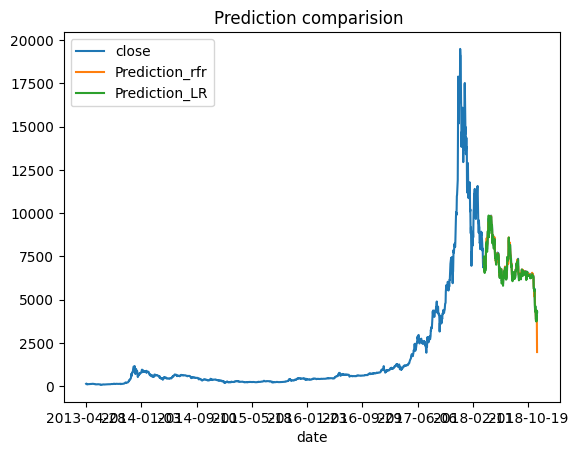

In [ ]:
score = pd.DataFrame(index = ["r2_score", "mean_squared_error"], columns= ["RandomForestRegressor", "LinearRegression"])

X_train, X_test, y_train, y_test = TestTrainpreperation(bitcoin_df)

bitcoin_df, score= RandomForestRegressor(bitcoin_df, X_train, X_test, y_train, y_test, temp, score)

bitcoin_df, score, Lrpredict = LinearRegressionModel(bitcoin_df, X_train, X_test, y_train, y_test, temp, score)

print(bitcoin_df[1800:])
print(score)
print(bitcoin_df[["close", "Prediction_rfr", "Prediction_LR",]].plot(title = "Prediction comparision "))



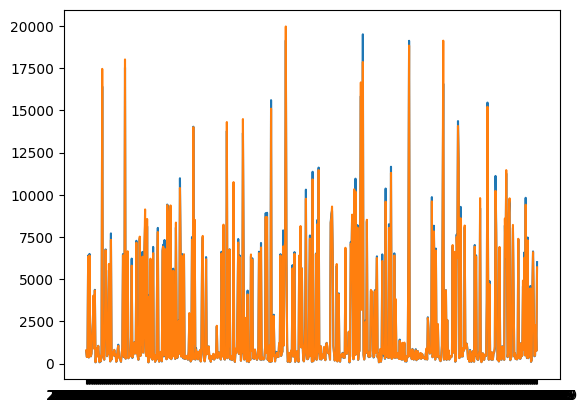

In [ ]:
plt.plot(y_test, label='Actual')
plt.plot(Lrpredict, label='Predicted')
print(bitcoin_df[["close", "Prediction_rfr", "Prediction_LR",]].plot(title = "Prediction comparision "))